# Wavelet Centroiding Code

- Using a scam image, find the center of Titan's disk relative to the slit in order to accurately determine the slit placement on Titan

In [25]:
from fits_dataclass import Image, ImageSet, Transform
import matplotlib.pyplot as plt
import numpy as np
import astroscrappy
import glob
import copy
import wavelet_centroiding as wc

In [2]:
#Load a set of sample scam images from 2018 observations
base_path = '/Users/ryleighfitzpatrick/TitanMethane/sample_imgs/'

files = glob.glob(base_path+'jul*.fits')
scams = ImageSet([Image.load(file) for file in files])
bkg = Image.load(base_path+'bkg_2.fits')



In [3]:
#Cosmic Correct scam images (as would already be done in the pipeline)

# Standard CR settings used in the pipeline for pre 2019 data
gain = 2.1
max_iter = 3
sig_clip = 5.0
sig_frac = 0.3
obj_lim = 5.0
readnoise=10.0

scams_cr = ImageSet([Image(_data=astroscrappy.detect_cosmics(s.data, pssl=0.0, gain=gain, 
                sigclip=sig_clip, sigfrac=sig_frac, objlim=obj_lim, 
                readnoise=readnoise, satlevel=np.inf, inmask=None,
                sepmed=False, cleantype='medmask', fsmode='median')[1],
            header = s.header) for s in scams])

bkg = astroscrappy.detect_cosmics(bkg.data, pssl=0.0, gain=gain, 
                sigclip=sig_clip, sigfrac=sig_frac, objlim=obj_lim, 
                readnoise=readnoise, satlevel=np.inf, inmask=None,
                sepmed=False, cleantype='medmask',fsmode='median')[1]

scams_bkg = [Image(_data=s.data-bkg, header=s.header) for s in scams_cr]

## Scale fainter half of detector
- note this step is only needed for some of the data
### TO DO:
 - determine what cause of scam detector brightness issue
 - how have other's have handled this?
 - generate criteria to determine if scaling is necessary

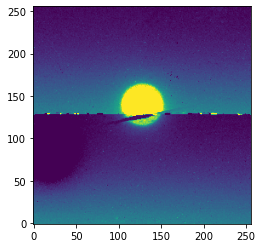

In [4]:
plt.imshow(scams_bkg[1].data, vmin=0, vmax=2000, origin='lower')

In [6]:
print(np.mean(scams_bkg[1].data[:128,:]))
print(np.mean(scams_bkg[1].data[129:,:]))

# Potential criteria to scale: If the mean of the two halves of the detecor is off by more than ~50

277.6677
457.9164


In [19]:
scale = np.round(np.mean(scams_bkg[1].data[129:,:])/np.mean(scams_bkg[1].data[:128,:]),2)
scaled = copy.copy(scams_bkg[1].data)
scaled[:128,:] = scams_bkg[1].data[:128,:]*scale

#Get rid of bad outlyer data
#TO DO: figure out why 2018 scams seem to be so much messier than 2017 
scaled[scaled < 10] = 0
scaled[scaled > 5000] = 5000


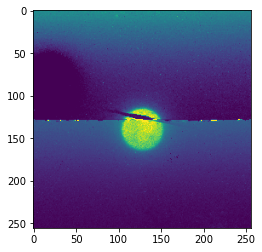

In [20]:
plt.imshow(scaled, vmin=0, vmax=3000)

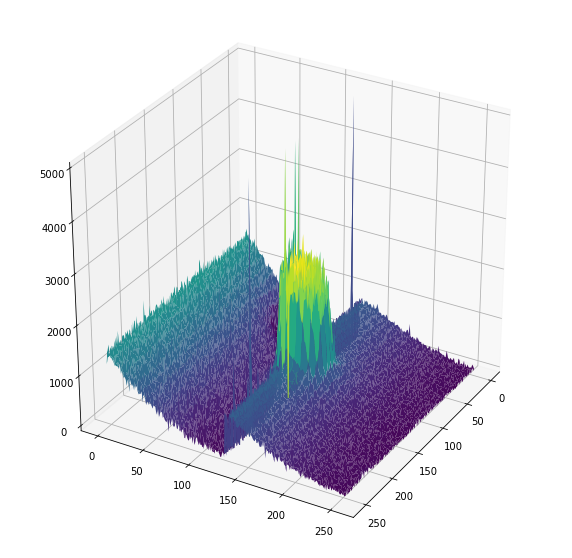

In [26]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x,y = np.meshgrid(range(256), range(256))

ax.plot_surface(x, y, scaled, cmap='viridis', edgecolor='none')
ax.view_init(elev=30, azim=30)


### Use a flat "Mexican Hat" wavelet

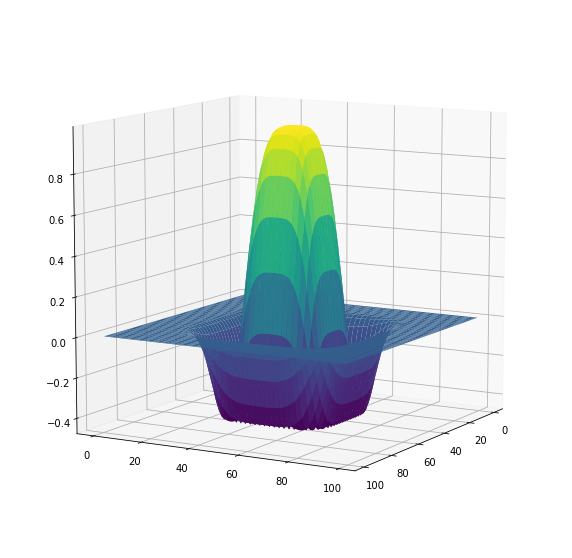

In [22]:
def ft_mexh(x, y):
    return (1. - (x**4. + y**4.))*np.exp(-0.5 * (x**4. + y**4.))

xx, yy = np.meshgrid(range(100), range(100))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

a = np.zeros(shape=(100,100))

for x, i in zip(np.linspace(-3,3, num=100), range(100)):
    for y, j in zip(np.linspace(-3,3, num=100), range(100)):
        a[i,j] = ft_mexh(x,y)

ax.plot_surface(xx, yy, a, cmap='viridis', edgecolor='none')
ax.view_init(elev=10, azim=30)




## Convolve image and Find Titan's Center
- Convolve the scam image using the mexican hat 2D continuous wavelet and find the peak to determine the center of Titan's disk

- Implemented in **wavelet_centroiding.get_center()**

In [89]:
imp.reload(wc)

<module 'wavelet_centroiding' from '/Users/ryleighfitzpatrick/TitanMethane/pipeline/wavelet_centroiding.py'>

In [90]:
# Let's examine what's happening in get_center()

# Continuous wavelet transform (only needed here to be able to plot)
from cwt_2d import cwt_2d
cwt = cwt_2d(scaled, [10], 'ft_mexh')
cwt = np.real(cwt[0])[:,:,0]

#Find center
peak = wc.get_center(scaled, [10], 'ft_mexh')


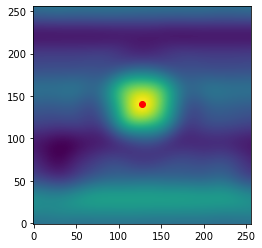

In [91]:
plt.imshow(cwt, origin='lower')
plt.plot(peak[0], peak[1], 'o', color='r')

# How does the peak finding algorithm work?

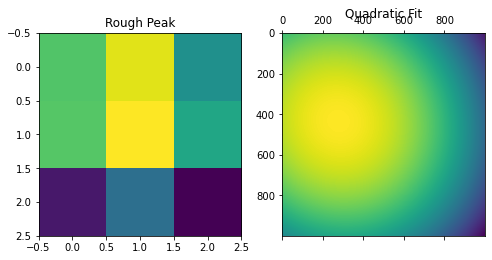

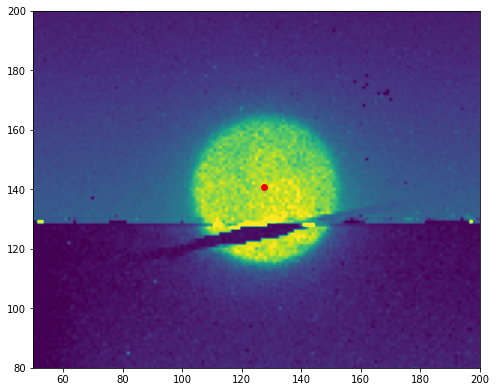

In [83]:
# First find the region of the peak (pixel accuracy)
rough_i, rough_j = wc.rough_peak2d(cwt)

#Select the 9 pixel neighborhood around the rough peak location
X = range(rough_i-1,rough_i+2)
Y = range(rough_j-1,rough_j+2)
neighborhood = cwt[X[0]:X[-1]+1, Y[0]:Y[-1]+1]

#Fit a 2D quadratic to the 9 pixel neighborhod to get center to subpixel accuracy
pfit = wc.polyfit2d(X, Y, neighborhood, order=2)
fn = wc.neg_quadratic_approx(pfit)

from scipy.optimize import minimize
peak = minimize(fn, [128, 140]).x

#Plot peak fitting
fig, ax = plt.subplots(1,2, figsize=(8,20))

ax[0].imshow(neighborhood)
ax[0].set_title('Rough Peak')

#
num = 1000
x,y = np.meshgrid(np.linspace(Y[0],Y[-1],num=num), np.linspace(X[0],X[-1],num=num))
fitted_surf = -1*fn([x,y])
ax[1].matshow(fitted_surf)
ax[1].set_title('Quadratic Fit')
plt.show()

#Plot image with center
fig = plt.figure(figsize=(8,8))
plt.imshow(scaled, vmin=0, vmax=3000)
plt.plot(peak[0], peak[1], 'o', color='r')
plt.xlim(50,200)
plt.ylim(80,200)
plt.show()



In [ ]:
# Get subpixel accuracty for center

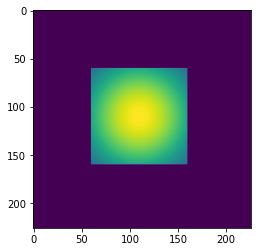

In [19]:
#Fake Data
x, y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
d = np.sqrt(x*x+y*y)
sigma, mu = 1.0, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )

fake_img = np.zeros((226,226))
fake_img[60:160, 60:160] = g

plt.imshow(fake_img)

In [20]:
fake_cwt = cwt_2d(fake_img, [10], 'ft_mexh')

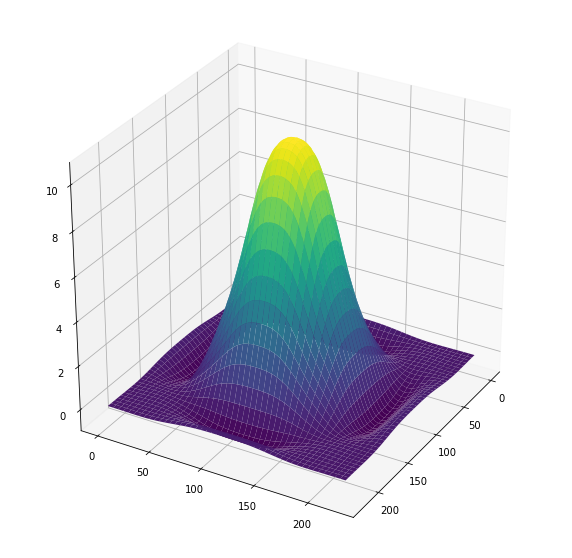

In [21]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x,y = np.meshgrid(range(226), range(226))

ax.plot_surface(x, y, np.real(fake_cwt[0])[:,:,0], cmap='viridis', edgecolor='none')

ax.view_init(elev=30, azim=30)


In [22]:
fp, fp_x, fp_y = peak2d(np.real(fake_cwt[0])[:,:,0])

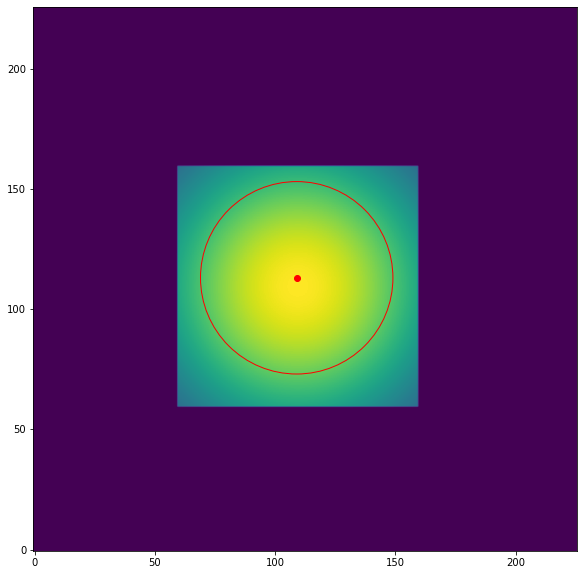

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

test[test < 10] = 0
test[test > 3000] = 3000
plt.imshow(fake_img, origin='lower')

plt.plot(fp_x, fp_y, 'o', color='r')

draw_circle = plt.Circle((fp_x, fp_y), 40, fill=None, color='r')
ax.add_artist(draw_circle)

#ax.set_xlim(80,170)
#ax.set_ylim(100,180)

## TO DO:
 - Create fake data to test this!
 - Can also get an idea of the uncertaintly

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x,y = np.meshgrid(range(256), range(256))

ax.plot_surface(x, y, np.real(cwt[0])[:,:,0], cmap='viridis', edgecolor='none')

ax.view_init(elev=30, azim=30)

#ax.scatter3D(peak_y, peak_x, peak, color='r')


In [ ]:
cwt2 = cwt_2d(test, [30], 'gaus')

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x,y = np.meshgrid(range(256), range(256))

ax.plot_surface(x, y, np.real(cwt2[0])[:,:,0], cmap='viridis', edgecolor='none')

ax.view_init(elev=30, azim=30)

In [ ]:
a= np.real(cwt[0])[:,:,0]
np.unravel_index(a.argmax(), a.shape)